In [22]:
import pandas as pd
import numpy as np
from pycaret.time_series import *
import matplotlib.pyplot as plt
import ephem

In [97]:
# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-phuket-tidegauge-2013_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df["DATE"] = df["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.set_index('DATE', inplace=True)
df = df.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)
df.dropna(inplace=True)
df = df.resample("H").mean()

In [98]:
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

In [99]:
# ลบค่าที่ซ้ำกันใน index
df = df[~df.index.duplicated(keep="last")]

In [100]:
# กำหนดความถี่ของข้อมูลเป็นชั่วโมง
df = df.asfreq("H")

In [101]:
# เติมค่าหายไปโดยใช้ Interpolation แบบ Time-based
df.interpolate(method='time', inplace=True)

In [102]:
df.isna().sum()

W_LEV_AVG    0
day          0
month        0
year         0
dtype: int64

In [103]:
# สร้างคอลัมน์ moon_phase (ค่าจาก 0-1)
def get_moon_phase(date):
    moon = ephem.Moon(date)
    phase = moon.phase / 100  # ปรับค่าให้อยู่ในช่วง 0-1
    return phase

df["moon_phase"] = df.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days & dark_moon_days
df["full_moon_days"] = df["moon_phase"].apply(lambda x: 1 if x >= 0.98 else 0)  # พระจันทร์เต็มดวง
df["dark_moon_days"] = df["moon_phase"].apply(lambda x: 1 if x <= 0.02 else 0)  # คืนเดือนมืด
df

,W_LEV_AVG,day,month,year,moon_phase,full_moon_days,dark_moon_days
DATE,,,,,,,
2013-10-01 07:00:00,0.495833,1,10,2013,0.144905,0,0
2013-10-01 08:00:00,0.577550,1,10,2013,0.142009,0,0
2013-10-01 09:00:00,0.477117,1,10,2013,0.139136,0,0
2013-10-01 10:00:00,0.199967,1,10,2013,0.136284,0,0
2013-10-01 11:00:00,-0.198067,1,10,2013,0.133454,0,0
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.144383,31,12,2023,0.796284,0,0
2023-12-31 20:00:00,-0.888383,31,12,2023,0.793123,0,0
2023-12-31 21:00:00,-0.470750,31,12,2023,0.789944,0,0


In [104]:
# ฟังก์ชันระบุฤดูกาลของไทย
def get_thai_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9, 10]:
        return 'rainy'
    else:
        return 'winter'

# เพิ่มคอลัมน์ฤดูกาล
df['season'] = df['month'].apply(get_thai_season)

# One-hot encoding ฤดูกาล
df = pd.get_dummies(df, columns=['season'], prefix='season')

# แปลงค่า True/False เป็น 1/0
df[['season_rainy', 'season_summer', 'season_winter']] = df[['season_rainy', 'season_summer', 'season_winter']].astype(int)
df

,W_LEV_AVG,day,month,year,moon_phase,full_moon_days,dark_moon_days,season_rainy,season_summer,season_winter
DATE,,,,,,,,,,
2013-10-01 07:00:00,0.495833,1,10,2013,0.144905,0,0,1,0,0
2013-10-01 08:00:00,0.577550,1,10,2013,0.142009,0,0,1,0,0
2013-10-01 09:00:00,0.477117,1,10,2013,0.139136,0,0,1,0,0
2013-10-01 10:00:00,0.199967,1,10,2013,0.136284,0,0,1,0,0
2013-10-01 11:00:00,-0.198067,1,10,2013,0.133454,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.144383,31,12,2023,0.796284,0,0,0,0,1
2023-12-31 20:00:00,-0.888383,31,12,2023,0.793123,0,0,0,0,1
2023-12-31 21:00:00,-0.470750,31,12,2023,0.789944,0,0,0,0,1


In [114]:
train_data = df[-8760:-72]
test_data = df[-72:]
train_data

,W_LEV_AVG,day,month,year,moon_phase,full_moon_days,dark_moon_days,season_rainy,season_summer,season_winter
DATE,,,,,,,,,,
2023-01-01 00:00:00,-0.650000,1,1,2023,0.699245,0,0,0,0,1
2023-01-01 01:00:00,-0.540000,1,1,2023,0.703136,0,0,0,0,1
2023-01-01 02:00:00,-0.350000,1,1,2023,0.707009,0,0,0,0,1
2023-01-01 03:00:00,-0.090000,1,1,2023,0.710862,0,0,0,0,1
2023-01-01 04:00:00,0.090000,1,1,2023,0.714696,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2023-12-28 19:00:00,-0.889317,28,12,2023,0.966873,0,0,0,0,1
2023-12-28 20:00:00,-0.311317,28,12,2023,0.965429,0,0,0,0,1
2023-12-28 21:00:00,0.263433,28,12,2023,0.963954,0,0,0,0,1


In [115]:
test_data

,W_LEV_AVG,day,month,year,moon_phase,full_moon_days,dark_moon_days,season_rainy,season_summer,season_winter
DATE,,,,,,,,,,
2023-12-29 00:00:00,0.742833,29,12,2023,0.959351,0,0,0,0,1
2023-12-29 01:00:00,0.326967,29,12,2023,0.957757,0,0,0,0,1
2023-12-29 02:00:00,-0.272983,29,12,2023,0.956134,0,0,0,0,1
2023-12-29 03:00:00,-0.929783,29,12,2023,0.954482,0,0,0,0,1
2023-12-29 04:00:00,-1.466067,29,12,2023,0.952801,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.144383,31,12,2023,0.796284,0,0,0,0,1
2023-12-31 20:00:00,-0.888383,31,12,2023,0.793123,0,0,0,0,1
2023-12-31 21:00:00,-0.470750,31,12,2023,0.789944,0,0,0,0,1


In [116]:
exp = TSForecastingExperiment()
exp.setup(
    data=train_data,
    target='W_LEV_AVG',
    session_id=123,
    fh=72,
    use_gpu=True,
    seasonal_period=[6, 12, 24],  # ตั้ง seasonality ตามน้ำขึ้นน้ำลง
    numeric_imputation_target='mean',  # เติมค่าที่หายไปด้วยค่าเฉลี่ย
    numeric_imputation_exogenous='mean',  # เติมค่าที่หายไปด้วยค่าเฉลี่ย
)

,Description,Value
0,session_id,123
1,Target,W_LEV_AVG
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(8688, 10)"
5,Transformed data shape,"(8688, 10)"
6,Transformed train set shape,"(8616, 10)"
7,Transformed test set shape,"(72, 10)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [118]:
best_model = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.2289,0.2183,0.2398,0.2956,2.7875,0.6902,0.7493,1.1600
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.2289,0.2183,0.2398,0.2956,2.7875,0.6902,0.7493,1.1733
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.2297,0.2258,0.2407,0.3056,2.1077,0.6973,0.7396,3.2367
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.2300,0.2189,0.2410,0.2964,2.8093,0.6944,0.7487,1.1800
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2534,0.2312,0.2655,0.3130,1.4959,0.7705,0.7206,1.2900
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.2565,0.2481,0.2686,0.3359,1.3016,0.7268,0.7262,2.8567
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.2579,0.2476,0.2702,0.3352,2.0317,0.7307,0.6717,2.5800
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.2644,0.2431,0.2769,0.3291,2.8813,0.7680,0.7310,2.5367
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.2891,0.2750,0.3029,0.3724,2.0580,0.7173,0.5042,3.3300
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.3828,0.3533,0.4010,0.4783,3.9302,1.0113,0.4193,1.2067


In [ ]:
# best_model = exp.create_model('lr_cds_dt') br_cds_dt

In [119]:
best_model = exp.create_model('et_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-12-16 23:00,0.3157,0.3006,0.3304,0.4070,1.3570,0.7472,0.6843
1,2023-12-19 23:00,0.1751,0.1697,0.1836,0.2300,1.2546,0.6633,0.8076
2,2023-12-22 23:00,0.2787,0.2741,0.2919,0.3707,1.2931,0.7698,0.6867
Mean,NaT,0.2565,0.2481,0.2686,0.3359,1.3016,0.7268,0.7262
SD,NaT,0.0595,0.0565,0.0621,0.0763,0.0422,0.0458,0.0576


In [120]:
best_model = exp.finalize_model(best_model)

In [121]:
exp.save_model(best_model, 'models/whatif_second_models')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('transformer_exogenous',
                             TransformerPipeline(steps=[('numerical_imputer',
                                                         Imputer(method='mean',
                                                                 random_state=123))])),
                            ('forecaster',
                             TransformedTargetForecaster(steps=[('transformer_target',
                                                                 TransformerPipeline(steps=[('numerical_imputer',
                                                                                             Imputer(method='mean',
                                                                                                     random_state=123))])),
                                                                ('model',
                                                                 ForecastingPipeline(steps=[('trans...
                                       

In [122]:
best_model = load_model('models\whatif_second_models')

Transformation Pipeline and Model Successfully Loaded


In [123]:
test_data.index = test_data.index.to_period("H")  # หรือ "D" ถ้าเป็น daily

In [124]:
# ทำนายค่า pm_2_5
forecast = predict_model(best_model, fh=72, X=test_data[-72:].drop(columns="W_LEV_AVG"))

# แสดงผลลัพธ์
print("Forecast:")
print(forecast)
print(test_data['W_LEV_AVG'][-72:])

Forecast:
                  y_pred
2023-12-29 00:00  0.7637
2023-12-29 01:00  0.3723
2023-12-29 02:00 -0.2335
2023-12-29 03:00 -0.9106
2023-12-29 04:00 -1.4668
...                  ...
2023-12-31 19:00 -1.2929
2023-12-31 20:00 -1.3303
2023-12-31 21:00 -1.1744
2023-12-31 22:00 -0.8397
2023-12-31 23:00 -0.4124

[72 rows x 1 columns]
DATE
2023-12-29 00:00    0.742833
2023-12-29 01:00    0.326967
2023-12-29 02:00   -0.272983
2023-12-29 03:00   -0.929783
2023-12-29 04:00   -1.466067
                      ...   
2023-12-31 19:00   -1.144383
2023-12-31 20:00   -0.888383
2023-12-31 21:00   -0.470750
2023-12-31 22:00    0.013400
2023-12-31 23:00    0.446050
Freq: H, Name: W_LEV_AVG, Length: 72, dtype: float64


In [125]:
# ดึงค่าจริงจาก test_data
actual = test_data['W_LEV_AVG']

# ดึงค่าทำนายจาก forecast
predicted = forecast['y_pred']


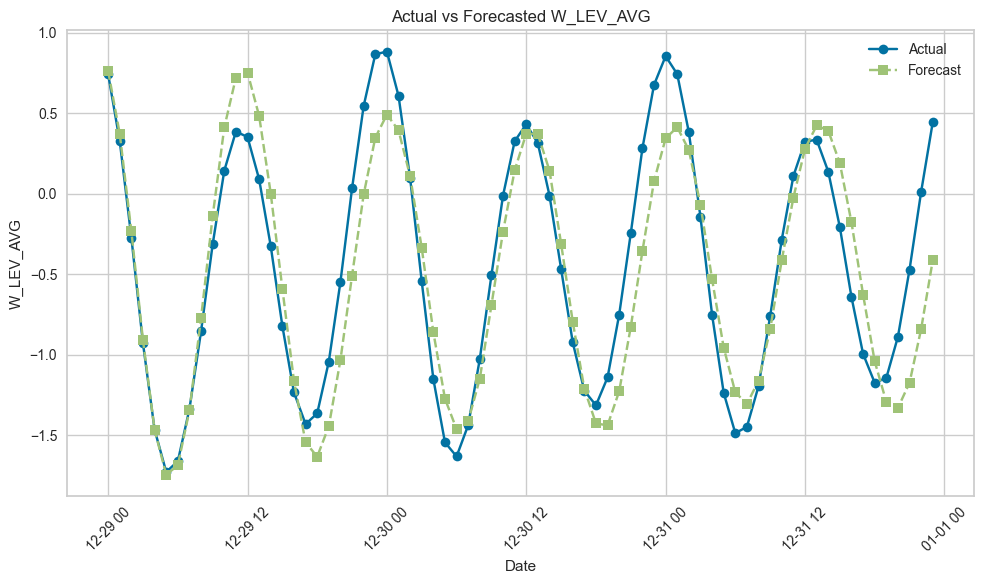

In [126]:
# แก้ไขการพล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(test_data.index.to_timestamp(), test_data['W_LEV_AVG'], label='Actual', marker='o')
plt.plot(predicted.index.to_timestamp(), predicted, label='Forecast', marker='s', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('W_LEV_AVG')
plt.title('Actual vs Forecasted W_LEV_AVG')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [127]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# คำนวณค่า MAE
mae = mean_absolute_error(test_data["W_LEV_AVG"], forecast)
mse = mean_squared_error(test_data["W_LEV_AVG"], forecast)
r2 = r2_score(test_data["W_LEV_AVG"], forecast)

# คำนวณ MAE% โดยใช้ค่าเฉลี่ยของค่าจริงเป็นตัวหาร
y_mean = np.mean(np.abs(test_data["W_LEV_AVG"].values))  # ใช้ค่าสัมบูรณ์ป้องกันค่าติดลบ
mae_percentage = (mae / (y_mean + 1e-8)) * 100  # บวก 1e-8 กันหารด้วย 0

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAE%: {mae_percentage:.2f}%")  # ใช้แทน MAPE
print(f"R2: {r2:.2f}")

MAE: 0.25
MSE: 0.10
MAE%: 34.20%
R2: 0.82


In [134]:
# วิธีแก้ไขปัญหาเมื่อใช้ plot_model กับตัวแปร exogenous

# 1. สร้างข้อมูล exogenous ในช่วงอนาคตที่ต้องการพยากรณ์
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

# สมมติว่า df คือ DataFrame ที่คุณใช้ฝึกโมเดล
last_date = df.index[-1]  # วันสุดท้ายในข้อมูลฝึก
forecast_horizon = 72  # จำนวนวันที่ต้องการพยากรณ์
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_horizon, freq='H')

# สร้าง DataFrame สำหรับตัวแปร exogenous ในอนาคต
exogenous_future = pd.DataFrame(index=future_dates)

# เพิ่มตัวแปร exogenous ตามวันที่
exogenous_future['day'] = exogenous_future.index.day
exogenous_future['month'] = exogenous_future.index.month
exogenous_future['year'] = exogenous_future.index.year

# คำนวณ moon_phase (นี่เป็นตัวอย่าง คุณต้องใช้การคำนวณที่ถูกต้อง)
# ตัวอย่างฟังก์ชันคำนวณ moon_phase
def get_moon_phase(date):
    moon = ephem.Moon(date)
    phase = moon.phase / 100  # Adjust the value to be between 0-1
    return phase

exogenous_future["moon_phase"] = exogenous_future.index.to_series().apply(get_moon_phase)

# คำนวณ full_moon_days และ dark_moon_days
# เพิ่มคอลัมน์ full_moon_days & dark_moon_days
exogenous_future["full_moon_days"] = exogenous_future["moon_phase"].apply(lambda x: 1 if x >= 0.98 else 0)  # พระจันทร์เต็มดวง
exogenous_future["dark_moon_days"] = exogenous_future["moon_phase"].apply(lambda x: 1 if x <= 0.02 else 0)  # คืนเดือนมืด

# กำหนดฤดูกาล - ตัวอย่างสำหรับประเทศไทย
def get_season(month):
    if 1 <= month <= 12:  # ตรวจสอบว่าเดือนอยู่ในช่วงที่ถูกต้อง
        if 6 <= month <= 10:  # มิถุนายน-ตุลาคม
            return 'rainy'
        elif 11 <= month <= 2:  # พฤศจิกายน-กุมภาพันธ์
            return 'winter'
        else:  # มีนาคม-พฤษภาคม
            return 'summer'
    return 0  # ถ้าเดือนอยู่นอกช่วง 1-12 ให้คืนค่า 0
    

# เพิ่มคอลัมน์ฤดูกาล
exogenous_future['season'] = exogenous_future['month'].apply(get_thai_season)

# One-hot encoding ฤดูกาล
exogenous_future = pd.get_dummies(exogenous_future, columns=['season'], prefix='season')

exogenous_future['season_rainy'] = 0
exogenous_future['season_summer'] = 0


# แปลงค่า True/False เป็น 1/0
exogenous_future[['season_rainy', 'season_summer', 'season_winter']] = exogenous_future[['season_rainy', 'season_summer', 'season_winter']].astype(int)

# ตรวจสอบว่าต้องเพิ่มตัวแปร exogenous อื่นๆ ที่ใช้ในการฝึกโมเดลหรือไม่
# ...

exogenous_future

,day,month,year,moon_phase,full_moon_days,dark_moon_days,season_winter,season_rainy,season_summer
2024-01-01 23:00:00,1,1,2024,0.701843,0,0,1,0,0
2024-01-02 00:00:00,2,1,2024,0.698266,0,0,1,0,0
2024-01-02 01:00:00,2,1,2024,0.694677,0,0,1,0,0
2024-01-02 02:00:00,2,1,2024,0.691076,0,0,1,0,0
2024-01-02 03:00:00,2,1,2024,0.687463,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2024-01-04 18:00:00,4,1,2024,0.443439,0,0,1,0,0
2024-01-04 19:00:00,4,1,2024,0.439435,0,0,1,0,0
2024-01-04 20:00:00,4,1,2024,0.435430,0,0,1,0,0
2024-01-04 21:00:00,4,1,2024,0.431427,0,0,1,0,0


In [135]:
exogenous_future.index = exogenous_future.index.to_period(freq='H')  # หรือ freq ที่ตรงกับข้อมูลเดิม

In [136]:
# ทำนายค่า pm_2_5
future_forecast = predict_model(best_model, fh=72, X=exogenous_future)

# แสดงผลลัพธ์
print("Forecast:")
print(future_forecast)
print(test_data['W_LEV_AVG'])


Forecast:
                  y_pred
2023-12-29 00:00  0.7920
2023-12-29 01:00  0.4433
2023-12-29 02:00 -0.1638
2023-12-29 03:00 -0.8480
2023-12-29 04:00 -1.4004
...                  ...
2023-12-31 19:00 -1.4346
2023-12-31 20:00 -1.2798
2023-12-31 21:00 -0.9048
2023-12-31 22:00 -0.4016
2023-12-31 23:00  0.1007

[72 rows x 1 columns]
DATE
2023-12-29 00:00    0.742833
2023-12-29 01:00    0.326967
2023-12-29 02:00   -0.272983
2023-12-29 03:00   -0.929783
2023-12-29 04:00   -1.466067
                      ...   
2023-12-31 19:00   -1.144383
2023-12-31 20:00   -0.888383
2023-12-31 21:00   -0.470750
2023-12-31 22:00    0.013400
2023-12-31 23:00    0.446050
Freq: H, Name: W_LEV_AVG, Length: 72, dtype: float64


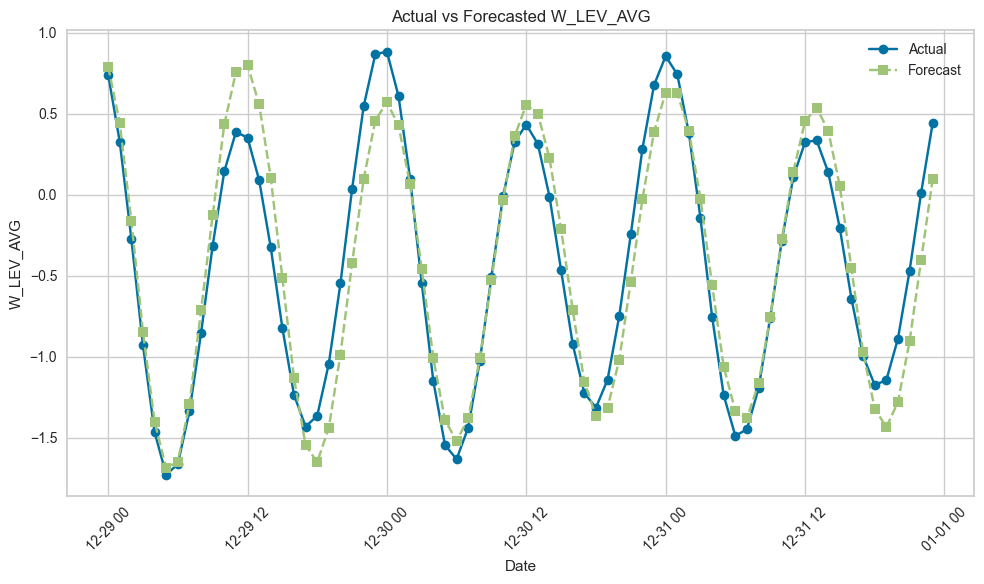

In [137]:
# แก้ไขการพล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(test_data.index.to_timestamp(), test_data['W_LEV_AVG'], label='Actual', marker='o')
plt.plot(future_forecast.index.to_timestamp(), future_forecast, label='Forecast', marker='s', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('W_LEV_AVG')
plt.title('Actual vs Forecasted W_LEV_AVG')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [138]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# คำนวณค่า MAE
mae = mean_absolute_error(test_data["W_LEV_AVG"], future_forecast)
mse = mean_squared_error(test_data["W_LEV_AVG"], future_forecast)
r2 = r2_score(test_data["W_LEV_AVG"], future_forecast)

# คำนวณ MAE% โดยใช้ค่าเฉลี่ยของค่าจริงเป็นตัวหาร
y_mean = np.mean(np.abs(test_data["W_LEV_AVG"].values))  # ใช้ค่าสัมบูรณ์ป้องกันค่าติดลบ
mae_percentage = (mae / (y_mean + 1e-8)) * 100  # บวก 1e-8 กันหารด้วย 0

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAE%: {mae_percentage:.2f}%")  # ใช้แทน MAPE
print(f"R2: {r2:.2f}")

MAE: 0.19
MSE: 0.06
MAE%: 26.04%
R2: 0.90


In [139]:
# 2. ใช้ plot_model พร้อมระบุ exogenous
exp.plot_model(best_model, plot="forecast", data_kwargs={"X": exogenous_future})